In [ ]:
#%pip install imblearn

In [85]:
import warnings

warnings.filterwarnings("ignore")

In [136]:
# Importar librerias
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer
from sklearn import tree
from sklearn import metrics
from sklearn import datasets
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt


%matplotlib inline

In [87]:
df_origin = pd.read_csv('https://raw.githubusercontent.com/jfelipeo/Proyecto_Analitica_II_Equipo-5/main/ecommerce-data.csv', sep=",")
df_transformed = df_origin.copy()

In [88]:
df_transformed = df_transformed.drop_duplicates()

In [89]:
df_transformed[['OperatingSystems', 'Browser', 'Region', 'TrafficType']] = df_transformed[['OperatingSystems', 'Browser', 'Region', 'TrafficType']].astype('object')
df_transformed[['Reviews','Informational','ProductRelated']] = df_transformed[['Reviews','Informational','ProductRelated']].astype('float')

In [37]:
df_transformed.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12205 entries, 0 to 12329
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Reviews                  12205 non-null  float64
 1   Reviews_Duration         12205 non-null  float64
 2   Informational            12205 non-null  float64
 3   Informational_Duration   12205 non-null  float64
 4   ProductRelated           12205 non-null  float64
 5   ProductRelated_Duration  12205 non-null  float64
 6   BounceRates              12205 non-null  float64
 7   ExitRates                12205 non-null  float64
 8   PageValues               12205 non-null  float64
 9   SpecialDay               12205 non-null  float64
 10  Month                    12205 non-null  object 
 11  OperatingSystems         12205 non-null  object 
 12  Browser                  12205 non-null  object 
 13  Region                   12205 non-null  object 
 14  TrafficType              12

In [91]:
cols_delete = ['Reviews_Duration', 'Informational_Duration','ProductRelated_Duration']
df_depured= df_transformed.drop(cols_delete, axis=1)
df_depured.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12205 entries, 0 to 12329
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Reviews           12205 non-null  float64
 1   Informational     12205 non-null  float64
 2   ProductRelated    12205 non-null  float64
 3   BounceRates       12205 non-null  float64
 4   ExitRates         12205 non-null  float64
 5   PageValues        12205 non-null  float64
 6   SpecialDay        12205 non-null  float64
 7   Month             12205 non-null  object 
 8   OperatingSystems  12205 non-null  object 
 9   Browser           12205 non-null  object 
 10  Region            12205 non-null  object 
 11  TrafficType       12205 non-null  object 
 12  VisitorType       12205 non-null  object 
 13  Weekend           12205 non-null  bool   
 14  Purchase          12205 non-null  bool   
dtypes: bool(2), float64(7), object(6)
memory usage: 1.3+ MB


In [93]:
df_depured.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Reviews,12205.0,2.338878,3.330436,0.0,0.000000,1.000000,4.000000,27.000000
Informational,12205.0,0.508726,1.275617,0.0,0.000000,0.000000,0.000000,24.000000
ProductRelated,12205.0,32.045637,44.593649,0.0,8.000000,18.000000,38.000000,705.000000
BounceRates,12205.0,0.020370,0.045255,0.0,0.000000,0.002899,0.016667,0.200000
ExitRates,12205.0,0.041466,0.046163,0.0,0.014231,0.025000,0.048529,0.200000
PageValues,12205.0,5.949574,18.653671,0.0,0.000000,0.000000,0.000000,361.763742
SpecialDay,12205.0,0.061942,0.199666,0.0,0.000000,0.000000,0.000000,1.000000


Revisión de los datos atípicos extremos

In [105]:
# Diccionario de valores límite para cada columna
valores_limite = {'Reviews': 25, 'Informational': 15, 'ProductRelated': 450, 'BounceRates':0.18, 'ExitRates': 0.2, 'PageValues': 150}

# Conteo de datos para cada columna
conteos = {}

# Iterar sobre las columnas y valores límite
for columna, limite in valores_limite.items():
    # Filtrar los datos de la columna que sean mayores o iguales al valor límite
    datos_filtrados = df_depured[df_depured[columna] >= limite][columna]
    # Contar el número de filas resultantes
    conteo = datos_filtrados.count()
    # Almacenar el conteo en el diccionario
    conteos[columna] = conteo

# Mostrar los conteos para cada columna
for columna, conteo in conteos.items():
    print("Datos mayores o iguales a", valores_limite[columna], "en la columna", columna + ":", conteo)

Datos mayores o iguales a 15 en la columna Reviews: 113
Datos mayores o iguales a 10 en la columna Informational: 18
Datos mayores o iguales a 450 en la columna ProductRelated: 9
Datos mayores o iguales a 0.18 en la columna BounceRates: 581
Datos mayores o iguales a 0.2 en la columna ExitRates: 585
Datos mayores o iguales a 150 en la columna PageValues: 27


In [106]:
y = df_depured.Purchase
X = df_depured.drop(['Purchase'], axis=1)

In [107]:
X_dummys = pd.get_dummies(X)
X_dummys.head()

,Reviews,Informational,ProductRelated,BounceRates,ExitRates,PageValues,SpecialDay,Weekend,Month_Aug,Month_Dec,...,TrafficType_14,TrafficType_15,TrafficType_16,TrafficType_17,TrafficType_18,TrafficType_19,TrafficType_20,VisitorType_New_Visitor,VisitorType_Other,VisitorType_Returning_Visitor
0,0.0,0.0,1.0,0.20,0.20,0.0,0.0,False,False,False,...,False,False,False,False,False,False,False,False,False,True
1,0.0,0.0,2.0,0.00,0.10,0.0,0.0,False,False,False,...,False,False,False,False,False,False,False,False,False,True
2,0.0,0.0,1.0,0.20,0.20,0.0,0.0,False,False,False,...,False,False,False,False,False,False,False,False,False,True
3,0.0,0.0,2.0,0.05,0.14,0.0,0.0,False,False,False,...,False,False,False,False,False,False,False,False,False,True
4,0.0,0.0,10.0,0.02,0.05,0.0,0.0,True,False,False,...,False,False,False,False,False,False,False,False,False,True


In [134]:
# LabelEncoder
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(y)

print(y[:10])
print(le.classes_)

[0 0 0 0 0 0 0 0 0 0]
[0 1]


# Desbalanceo de Clases

<Axes: xlabel='Purchase'>

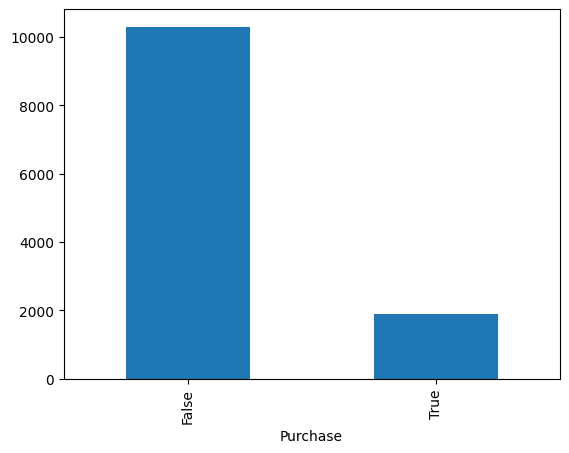

In [133]:
# Identificación de ejemplos de entrenamiento por clases
df_depured['Purchase'].value_counts().plot(kind='bar')



Por tratarse de un desbalanceo, vamos a realizar el submuestreo aleatorio con imblearn

In [135]:
# importar libreria
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

sub = RandomUnderSampler(random_state=42) 
# fit predictor and target variable
X_sub, y_sub = sub.fit_resample(X_dummys, y)

print('original dataset shape:', Counter(y))
print('Resample dataset shape', Counter(y_sub))

original dataset shape: Counter({0: 10297, 1: 1908})
Resample dataset shape Counter({0: 1908, 1: 1908})


# Modelado: Aplicación de técnicas de ML

## Modelo 1: Decision Tree Classifier



In [138]:

# split de datos en train y test
X_train, X_test, y_train, y_test = train_test_split(X_dummys, y, test_size=0.2,random_state=0)

In [139]:
# Entrenamiento del modelo

clf = tree.DecisionTreeClassifier(
          criterion = 'gini',
          max_depth = 6,
          max_leaf_nodes=10,
          random_state=0)
clf.fit(X_sub, y_sub)

DecisionTreeClassifier(max_depth=6, max_leaf_nodes=10, random_state=0)

### Metricas de desempeño

In [141]:
# Métricas de desempeño
# ==============================================================================
print ("Train - Accuracy :", metrics.accuracy_score(y_train, clf.predict(X_train)))
print ("Train - classification report:\n", metrics.classification_report(y_train, clf.predict(X_train), digits=4))
print ("Test - Accuracy :", metrics.accuracy_score(y_test, clf.predict(X_test)))
print ("Test - classification report:\n", metrics.classification_report(y_test, clf.predict(X_test), digits=4))


Train - Accuracy : 0.8471937730438345
Train - classification report:
               precision    recall  f1-score   support

           0     0.9731    0.8421    0.9029      8234
           1     0.5072    0.8745    0.6420      1530

    accuracy                         0.8472      9764
   macro avg     0.7401    0.8583    0.7724      9764
weighted avg     0.9001    0.8472    0.8620      9764

Test - Accuracy : 0.8533387955755838
Test - classification report:
               precision    recall  f1-score   support

           0     0.9692    0.8536    0.9077      2063
           1     0.5160    0.8519    0.6427       378

    accuracy                         0.8533      2441
   macro avg     0.7426    0.8527    0.7752      2441
weighted avg     0.8990    0.8533    0.8667      2441



Analisis:
* Accuracy (Precisión): El accuracy es una medida de qué tan bien el modelo clasifica correctamente las muestras. En el conjunto de entrenamiento, el accuracy es del 84.72% y en el conjunto de prueba es del 85.33%. Estos valores son similares, lo que sugiere que el modelo no está sobreajustando o subajustando demasiado los datos de entrenamiento.

* Precision (Precisión): La precisión se refiere a la proporción de instancias clasificadas como positivas que son verdaderamente positivas. En el conjunto de entrenamiento, la precisión para la clase 0 es del 97.31% y para la clase 1 es del 50.60%. En el conjunto de prueba, la precisión para la clase 0 es del 96.92% y para la clase 1 es del 51.60%. Esto indica que el modelo tiene una alta precisión para la clase mayoritaria (0) pero una precisión más baja para la clase minoritaria (1).

* Recall (Sensibilidad): El recall se refiere a la proporción de instancias positivas que fueron correctamente identificadas por el modelo. En el conjunto de entrenamiento, el recall para la clase 0 es del 84.21% y para la clase 1 es del 87.45%. En el conjunto de prueba, el recall para la clase 0 es del 85.36% y para la clase 1 es del 85.19%. Esto indica que el modelo tiene una buena capacidad para identificar correctamente las instancias positivas en ambas clases.

* F1-score (Puntaje F1): El puntaje F1 es la media armónica de precisión y recall. Es útil cuando tienes un desequilibrio en las clases. En el conjunto de entrenamiento, el puntaje F1 para la clase 0 es del 90.29% y para la clase 1 es del 64.20%. En el conjunto de prueba, el puntaje F1 para la clase 0 es del 90.77% y para la clase 1 es del 64.27%. Estos valores combinan la precisión y el recall para proporcionar una medida única de rendimiento

Finalmente, se concluye que parace tener buenos rendimientos en terminos de precision y recall en ambos conjuntos de datos. En contraste, se ve una diferencia notable en la precision entre las caracteristicas de la variable objetivo, donde el modelo puede presentar dificultades para predicir la clase minoritaria, es decir para predecir los valores verdaderos (1). **Lo anterior es sin haber tratado los outliers.**